In [1]:
import os
from rfdetr import RFDETRBase

output_dir = "../working"
yolo_dataset_dir = os.path.join(output_dir, "yolo_dataset")
yolo_images = os.path.join(yolo_dataset_dir, "images")
yolo_images_train = os.path.join(yolo_images, "train")
yolo_images_val = os.path.join(yolo_images, "valid")
yolo_labels_train = os.path.join(yolo_dataset_dir, "labels", "train")
yolo_labels_val = os.path.join(yolo_dataset_dir, "labels", "valid")

model = RFDETRBase()
history = []


def callback2(data):
    history.append(data)


model.callbacks["on_fit_epoch_end"].append(callback2)

model.train(
    dataset_dir=yolo_images,
    epochs=50,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    output_dir="../working/yolo_model",
)

2025-04-22 17:34:20.432025: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 17:34:20.439913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745336060.448923   53788 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745336060.451580   53788 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745336060.458639   53788 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading pretrain weights


num_classes mismatch: model has 90 classes, but your dataset has 1 classes
reinitializing your detection head with 1 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir ../working/yolo_model' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=1, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=50, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads

fatal: not a git repository (or any of the parent directories): .git


Epoch: [0]  [  0/203]  eta: 0:06:25  lr: 0.000100  class_error: 0.00  loss: 22.7459 (22.7459)  loss_ce: 0.1283 (0.1283)  loss_bbox: 2.5172 (2.5172)  loss_giou: 2.5335 (2.5335)  loss_ce_0: 0.1079 (0.1079)  loss_bbox_0: 3.1627 (3.1627)  loss_giou_0: 2.6810 (2.6810)  loss_ce_1: 0.1277 (0.1277)  loss_bbox_1: 2.6250 (2.6250)  loss_giou_1: 2.6244 (2.6244)  loss_ce_enc: 0.1153 (0.1153)  loss_bbox_enc: 3.3115 (3.3115)  loss_giou_enc: 2.8113 (2.8113)  loss_ce_unscaled: 0.1283 (0.1283)  class_error_unscaled: 0.0000 (0.0000)  loss_bbox_unscaled: 0.5034 (0.5034)  loss_giou_unscaled: 1.2668 (1.2668)  cardinality_error_unscaled: 0.7500 (0.7500)  loss_ce_0_unscaled: 0.1079 (0.1079)  loss_bbox_0_unscaled: 0.6325 (0.6325)  loss_giou_0_unscaled: 1.3405 (1.3405)  cardinality_error_0_unscaled: 0.7500 (0.7500)  loss_ce_1_unscaled: 0.1277 (0.1277)  loss_bbox_1_unscaled: 0.5250 (0.5250)  loss_giou_1_unscaled: 1.3122 (1.3122)  cardinality_error_1_unscaled: 0.7500 (0.7500)  loss_ce_enc_unscaled: 0.1153 (0.1153

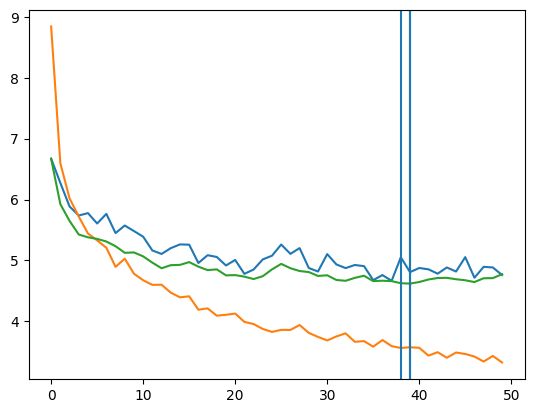

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot([step["test_loss"] for step in history])
plt.plot([step["train_loss"] for step in history])
plt.plot([step["ema_test_loss"] for step in history])

ema_test_loss = np.array([step["ema_test_loss"] for step in history])
plt.axvline(np.argmin(ema_test_loss))

prct_5 = np.percentile(ema_test_loss, 5)
indices = np.where(ema_test_loss < prct_5)[0]
plt.axvline(np.argmin(ema_test_loss))
plt.axvline(indices[0])

plt.show()

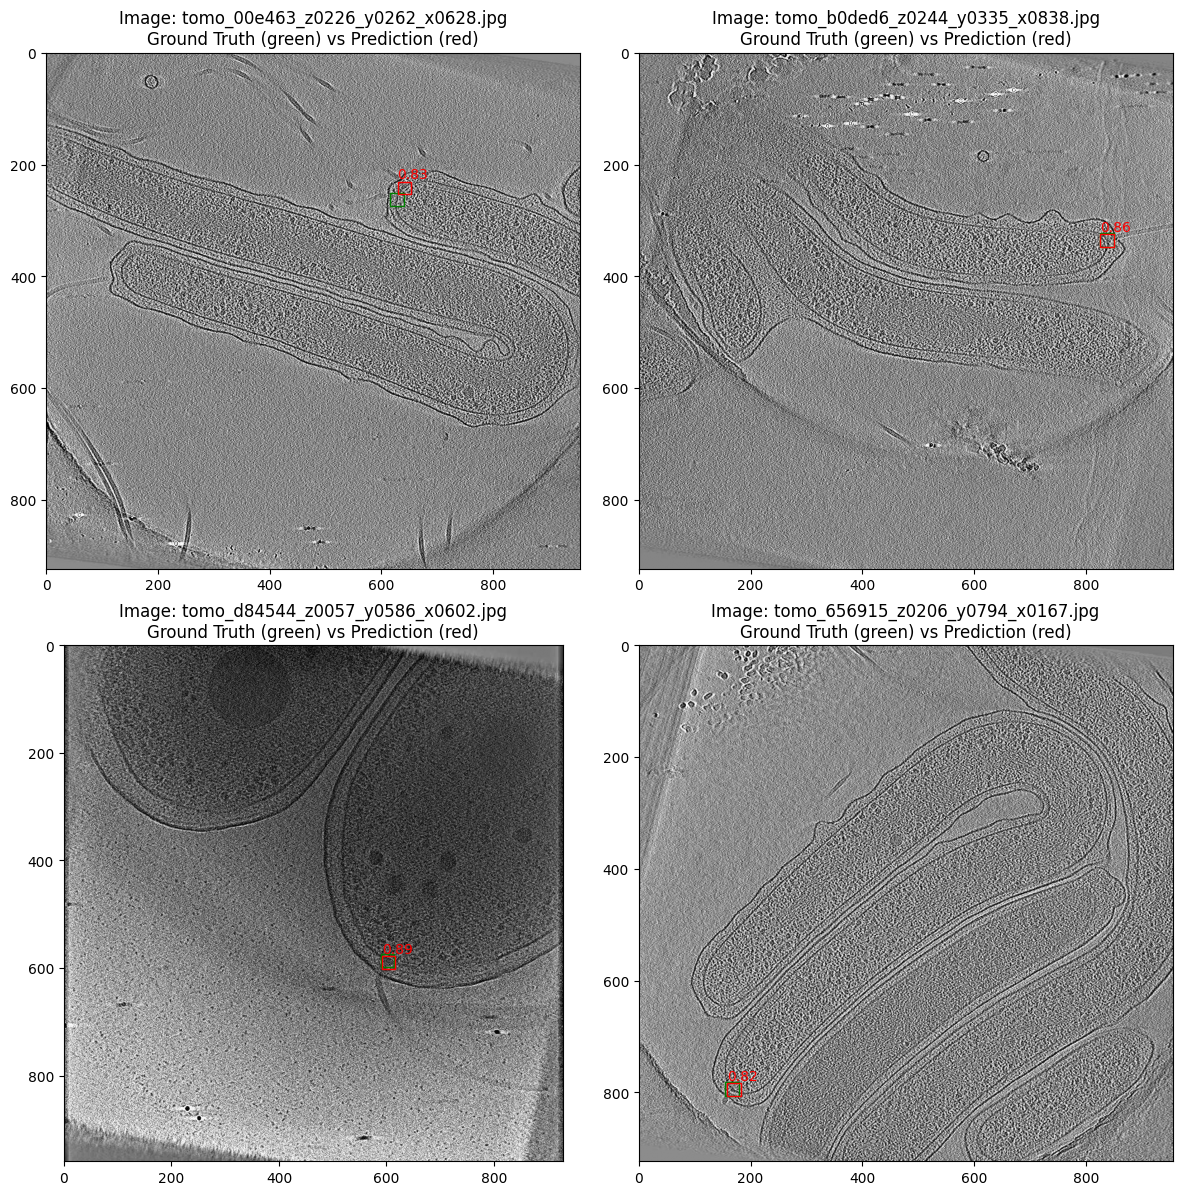

In [9]:
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np


def predict_on_samples(model, num_samples=4):
    """
    Run predictions on random validation samples and display results

    Args:
        model: Trained YOLO model
        num_samples (int): Number of random samples to test
    """
    # Get validation images
    val_dir = os.path.join(yolo_dataset_dir, "images", "valid")
    if not os.path.exists(val_dir):
        print(f"Validation directory not found at {val_dir}")
        # Try train directory instead if val doesn't exist
        val_dir = os.path.join(yolo_dataset_dir, "images", "train")
        print(f"Using train directory for predictions instead: {val_dir}")

    if not os.path.exists(val_dir):
        print("No images directory found for predictions")
        return

    val_images = os.listdir(val_dir)

    if len(val_images) == 0:
        print("No images found for prediction")
        return

    # Select random samples
    num_samples = min(num_samples, len(val_images))
    samples = random.sample(val_images, num_samples)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, img_file in enumerate(samples):
        if i >= len(axes):
            break

        img_path = os.path.join(val_dir, img_file)
        # Run prediction
        results = predict(model, img_path)

        # Load and display the image
        img = Image.open(img_path)
        axes[i].imshow(np.array(img), cmap="gray")

        # Draw ground truth box if available (from filename)
        try:
            # This assumes your filenames contain coordinates in a specific format
            parts = img_file.split("_")
            y_part = [p for p in parts if p.startswith("y")]
            x_part = [p for p in parts if p.startswith("x")]

            if y_part and x_part:
                y_gt = int(y_part[0][1:])
                x_gt = int(x_part[0][1:].split(".")[0])

                box_size = 24
                rect_gt = Rectangle(
                    (x_gt - box_size // 2, y_gt - box_size // 2),
                    box_size,
                    box_size,
                    linewidth=1,
                    edgecolor="g",
                    facecolor="none",
                )
                axes[i].add_patch(rect_gt)
        except:
            pass  # Skip ground truth if parsing fails

        # Draw predicted boxes (red)
        if len(results.xyxy) > 0:
            boxes = results.xyxy
            confs = results.confidence

            for box, conf in zip(boxes, confs):
                x1, y1, x2, y2 = box
                rect_pred = Rectangle(
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                )
                axes[i].add_patch(rect_pred)
                axes[i].text(x1, y1 - 5, f"{conf:.2f}", color="red")

        axes[i].set_title(
            f"Image: {img_file}\nGround Truth (green) vs Prediction (red)"
        )

    plt.tight_layout()

    # Save the predictions plot
    plt.savefig(os.path.join(output_dir, "predictions.png"))
    plt.show()


predict_on_samples(model, num_samples=4)

In [4]:
from logging import Logger
import torch
import supervision as sv

from PIL import Image
import torchvision.transforms.functional as F

image = Image.open(
    "../working/yolo_dataset/images/valid/tomo_00e463_z0228_y0262_x0628.jpg"
).convert("RGB")


def predict(
    model,
    image_or_path,
    threshold: float = 0.5,
):
    """
    Run prediction on a single image

    Args:
        model: Trained YOLO model
        image: Image tensor
    """

    with torch.inference_mode():
        if isinstance(image_or_path, str):
            image_or_path = Image.open(image_or_path).convert("RGB")
            w, h = image_or_path.size

        if not isinstance(image_or_path, torch.Tensor):
            image = F.to_tensor(image_or_path)
            _, h, w = image.shape
        else:
            Logger.warning(
                "image_or_path is a torch.Tensor\n",
                "we expect an image divided by 255 at (C, H, W)",
            )
            assert image_or_path.shape[0] == 3, "image must have 3 channels"
            h, w = image_or_path.shape[1:]

        image = image.to(model.model.device)
        image = F.normalize(image, model.means, model.stds)
        image = F.resize(image, (model.model.resolution, model.model.resolution))

        predictions = model.model.model.forward(image[None, :])
        bboxes = predictions["pred_boxes"]
        results = model.model.postprocessors["bbox"](
            predictions,
            target_sizes=torch.tensor([[h, w]], device=model.model.device),
        )
        scores, labels, boxes = [], [], []
        for result in results:
            scores.append(result["scores"])
            labels.append(result["labels"])
            boxes.append(result["boxes"])

        scores = torch.stack(scores)
        labels = torch.stack(labels)
        boxes = torch.stack(boxes)

        keep_inds = scores > threshold
        boxes = boxes[keep_inds]
        labels = labels[keep_inds]
        scores = scores[keep_inds]
        detections = sv.Detections(
            xyxy=boxes.cpu().numpy(),
            class_id=labels.cpu().numpy(),
            confidence=scores.cpu().numpy(),
        )
        return detections


predictions = predict(model, image)

In [7]:
predictions

Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={}, metadata={})